***
University of Strasbourg 
***



### Packages

In [ ]:
!pip uninstall tensorflow -y
!pip install tensorflow==2.14

In [1]:
!pip install comet_ml
!pip install tqdm

### Imports

In [2]:
# Import Comet package for tracking the experiments

from comet_ml import Experiment
### TODO: Signup for a free account at https://www.comet.ml and paste your API key below
exp = Experiment(
    api_key="ZZUpHIDC4hsMQ3ps3tMOe2qWL",
    project_name='applied-ai-gan-students')
### END OF TODO


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/jecajeca/applied-ai-gan-students/74a0cc26b42346ac86fdc4efd74f2b1b



In [3]:
# Import models, layers, optmisers
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Reshape, Conv2DTranspose, Conv2D, Flatten, LeakyReLU, ReLU,BatchNormalization, Embedding,Multiply,Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10, mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras import initializers
#other packages
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import sys
from skimage.transform import resize


### **Global variables** 

In [4]:
# Globals variables : 
noise_input_shape = 100
batch_size = 128
num_classes = 10

### Utils functions (plotting, logging)
You can ignore these for the moment

In [5]:
# Function to plot generated images : 
'''
Arguments : 
epoch - training epoch
generator - generator model from epoch epoch
exp - Comet.ml callback
examples - number of images to be plotted
dim - (rows, cols) of figure in which images will be plotted
figsize - size of the figure
prefix - prefix for the filename of the saved plot
'''
#TODO: Take a look how generator produce image
def plot_generated_images(epoch, generator, exp, examples=10, dim=(2, 5), figsize=(5, 5), prefix='dataset'):
    # Random input vector
    noise = tf.random.normal(shape=[examples, noise_input_shape])
    labels = tf.reshape(tf.range(start=0, limit=num_classes),[-1,1])
    # Generate images
    generated_images =(generator([noise,labels],training=False)).numpy()
    # Convert images into range [0-255] and convert to uint8 for proper plotting
    generated_images = ((generated_images * 127.5) + 127.5).astype('uint8')
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(np.squeeze(generated_images[i]))
        plt.gca().set_title("Digit: %d" % labels[i])
        plt.axis('off')
    plt.tight_layout()
    #plt.savefig(prefix+'_gan_generated_image %d.png' % epoch)
    # Log plotted figure into Comet.ml
    exp.log_figure(figure_name='generated_images_step'+str(epoch))
    plt.close()

def plot_generated_images_random(epoch, generator, exp, examples=100, dim=(10, 10), figsize=(10, 10), prefix='dataset'):
    # Random input vector
    noise = tf.random.normal(shape=[examples, noise_input_shape])
    labels = tf.random.uniform(shape=[examples], minval=0, maxval=num_classes, dtype=tf.int32)
    # Generate images
    generated_images =(generator([noise,labels],training=False)).numpy()
    # Convert images into range [0-255] and convert to uint8 for proper plotting
    generated_images = ((generated_images * 127.5) + 127.5).astype('uint8')
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(np.squeeze(generated_images[i]))
        plt.gca().set_title("Digit: %d" % labels[i])
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('final_gan_generated_image.png')
    # Log plotted figure into Comet.ml
    exp.log_figure(figure_name='final_gan_generated_image.png')
    plt.close()
# Function to plot real images : 
'''
Arguments : 
X_train - real dataset images (or batch of real dataset images)
exp - Comet.ml callback
examples - number of images to be plotted
dim - (rows, cols) of figure in which images will be plotted
figsize - size of the figure
prefix - prefix for the filename of the saved plot

'''
def plot_real_images(X_train,y_train,exp, examples=25, dim=(5, 5), figsize=(5, 5), prefix='dataset'):
    print(X_train.shape)
    real_images = X_train[:examples]
    print(real_images.shape)
    real_images = ((real_images.numpy() * 127.5) + 127.5).astype('uint8')
    print(real_images.shape)
    plt.figure(figsize=figsize)
    for i in range(real_images.shape[0]):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(np.squeeze(real_images[i]))
        plt.gca().set_title("Digit: %d" % y_train[i])
        plt.axis('off')
    plt.tight_layout()
   # plt.savefig(prefix+'_gan_real_image %d.png')
    # Log plotted figure into Comet.ml
    exp.log_figure(figure_name='real_images.png')
    plt.close()

# Comet logging gradinets distributions (vanishing gradients)
def get_gradients(gradmap, grads, model):
    for grad, param in zip(grads, model.trainable_variables):
        gradmap.setdefault(param.name, 0)
        gradmap[param.name] += grad

    return gradmap

def log_histogram(experiment, gradmap, step, prefix=None):
    for k, v in gradmap.items():
        experiment.log_histogram_3d(v, name="%s/%s" % (prefix, k), step=step)


## **GAN model**

**Conditional  Generator** : 

*Input*: Noise (shape=(100,)), label (shape = (1,num_classes)).

*Output*: Image (32,32,3) 
 
**Conditional Discriminator :**
 
*Input*: Generated image and real image (32,32,3), label added as a channel to input image.

*Output*: number $\in [0,1]$, represents is input real or fake (0 fake, 1 real)

### Generator : 


In [6]:
# Function to create generator
def create_generator(noise_input_shape=100,out_channels=3):
  # Input noise is a vector of length 100 (for example)
  input = Input(shape=(noise_input_shape,))
  filters = 256
  k_size = 4
  g = Reshape((1,1,noise_input_shape))(input)
  g = Conv2DTranspose(filters,(k_size,k_size),strides=1)(g)
  g = BatchNormalization()(g)
  g = LeakyReLU(alpha=0.2)(g)
 
  ### TODO: complete the model (see https://keras.io/layers/convolutional/), all leakyReLu layers to have alpha=0.2, 4x4 convolution, and (2,2) stride
  # Upsampling blocks
  for i in range(1,4):
    f = filters//(2**i)
    # Spatial upsampling
    g = Conv2DTranspose(f, (k_size, k_size), strides=(2, 2), padding='same')(g)
    g = BatchNormalization()(g)
    g = LeakyReLU(alpha=0.2)(g)

  # N.B. Number of channels (filters) in last layer needs to be 3 (output should be an RGB image), with 3x3 convolution
  # Activation function in last layer should be tanh to match real images which are in the range [-1,1]
  g = Conv2D(out_channels, (3, 3), activation='tanh', padding='same')(g)
  ### END OF TODO
  
  # Make the model
  model = Model(inputs=input, outputs=g)

  # Model doesn't need to be compiled because it will be trained in combination with discriminator (new model will be created)
  return model

In [13]:
#TODO :
def create_conditional_generator(num_classes,noise_input_shape,out_channels=3):
  # Random noise vector z
  z = Input(shape=(noise_input_shape, ))

  # Conditioning label: integer 0-9 specifying the number G should generate
  label = Input(shape=(1, ), dtype='int32')

  # Label embedding: Could be done in a various ways
  # Concatantion with noise can result in generator which igonres noise, producing a single output for each class.
  # Using embedding layers is another option to mix noise and class lables (in structured and learnable way)
  # ----------------
  # Turns labels into dense vectors of size z_dim
  # Produces 3D tensor with shape (batch_size, 1, z_dim) 
  label_embedding = Embedding(num_classes, noise_input_shape, input_length=1)(label)

  # Flatten the embedding 3D tensor into 2D tensor with shape (batch_size, z_dim)
  label_embedding = Flatten()(label_embedding)

  # Element-wise product of the vectors z and the label embeddings
  joined_representation =  Multiply()([z, label_embedding]) # TODO: Experiment with Concatanate!

  #TODO : create generator
  generator = create_generator(noise_input_shape,out_channels)
  #TODO create conditional generator (use previously created generator and joined_representation)
  conditioned_img = generator(joined_representation)

  # make model
  model =  Model([z, label], conditioned_img)
  return model

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 1, 100)       1000        ['input_11[0][0]']               
                                                                                                  
 input_10 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 flatten_3 (Flatten)            (None, 100)          0           ['embedding_3[0][0]']            
                                                                                            

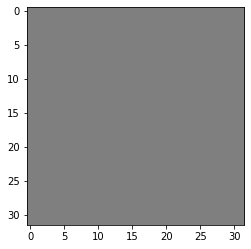

In [14]:
# Test generator
g = create_conditional_generator(num_classes,noise_input_shape,out_channels=3)
g.summary()
noise = tf.random.normal([1,noise_input_shape])
gen_img = g([noise,1],training=False).numpy()
plt.imshow(((gen_img[0,:,:]* 127.5) + 127.5).astype('uint8'))

### Discriminator: 




In [ ]:
# Function to create discriminator
def create_discriminator(input_shape):
    # Discriminator input has the same shape as the original dataset image shape (i.e. the same as the generator output)
    input = Input(input_shape)
    filters = 64
    k_size= 3
    d = Conv2D(filters, (k_size, k_size),padding='same')(input)
    #d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    for i in range(1,4):
      f = filters*(2 ** i)
      d = Conv2D(f, (k_size, k_size), strides=(2, 2),padding='same')(d)
      #d = BatchNormalization()(d)
      d = LeakyReLU(alpha=0.2)(d)

    
    d = Flatten()(d)
    # Output is one number

    d = Dense(1)(d)
    ### END OF TODO
    
    model = Model(inputs = input,outputs=d)
    return model


In [ ]:
def create_conditional_discriminator(input_shape,num_classes):
  # Input image
  img = Input(shape=input_shape)

  # Label for the input image
  label = Input(shape=(1, ), dtype='int32')

  # Label embedding:
  # ----------------
  # Turns labels into dense vectors of size z_dim
  # Produces 3D tensor with shape (batch_size, 1, input_shape[0]*input_shape[1]*1)
  label_embedding = Embedding(num_classes,
                              input_shape[0]*input_shape[1],
                              input_length=1)(label)

  # Flatten the embedding 3D tensor into 2D tensor with shape (batch_size, 28*28*1)
  label_embedding = Flatten()(label_embedding)

  # Reshape label embeddings to have same dimensions as input images
  label_embedding = Reshape((input_shape[0],input_shape[1],1))(label_embedding)

  # Concatenate images with their label embeddings
  concatenated = Concatenate(axis=-1)([img, label_embedding])
  discriminator = create_discriminator((input_shape[0],input_shape[1],input_shape[2]+1))

  # Predict disciminator outcome for conncataned tensor
  classification = discriminator(concatenated)
  # make model 
  model = Model([img, label], classification)
  return model


In [ ]:
# Test discriminator
d = create_conditional_discriminator((32,32,3),num_classes)
d.summary()
decision = d([gen_img,np.ones(gen_img.shape[0])])
#print(decision)

### Loss functions and optimisers


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = (real_loss + fake_loss)/2.0
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)

#  Dataset

In [ ]:
# Load dataset
dataset='mnist' #'cifar'
if dataset=='mnist':
  (x_train, y_train), (_, _) = mnist.load_data() 
  out_channels = 1
  x_train = x_train[...,np.newaxis]
elif dataset=='cifar':
  (x_train, y_train), (_, _) = cifar10.load_data()
  out_channels = 3
else:
  sys.exit('Unknown dataset')
  
# Normalise data to the range (-1,1)
x_train = (x_train.astype(np.float32) - 127.5) / 127.5

y_train = y_train.astype(np.int32)

# Get shape of images from original dataset (used to specify discriminator input shape)
init_shape = x_train.shape[1:]

# Training details
batch_count = x_train.shape[0] // batch_size # how many iteration per epoch



# Prepare models and resize dataset

In [ ]:
#Make models
generator = create_conditional_generator(num_classes,noise_input_shape,out_channels)
shape = generator.output_shape[1:]
discriminator = create_conditional_discriminator(shape,num_classes)

# Log and plot progress (Comet.ml)
exp.get_callback('keras').set_model(generator)


In [ ]:
def parse_function(img, label):
    image = tf.image.resize(img,(shape[0],shape[1]))
    return image, label
# make trainig set
train_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_dataset = train_dataset.shuffle(x_train.shape[0]) 
train_dataset = train_dataset.map(parse_function, num_parallel_calls=4)
train_dataset = train_dataset.batch(batch_size)

# GAN training

## Training step function

In [ ]:
#TODO
@tf.function
def train_step(real_images,real_lbls):

  
  noise =  tf.random.normal([real_images.shape[0], noise_input_shape]) 
  
  with tf.GradientTape() as disc_tape:
    generated_images = generator([noise,real_lbls], training=True)
    real_output = discriminator([real_images,real_lbls], training=True)
    fake_output = discriminator([generated_images,real_lbls], training=True)
    disc_loss = discriminator_loss(real_output, fake_output)
  
  
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
  # Update the weights of the discriminator using the discriminator optimizer
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  noise =  tf.random.normal([real_images.shape[0], noise_input_shape])
  gen_lbl = tf.random.uniform((real_images.shape[0],1),minval=0,maxval=num_classes,dtype=tf.int32)
  with tf.GradientTape() as gen_tape:
      # Generate fake images using the generator
      generated_images = generator([noise,gen_lbl], training=True)
      # Get the discriminator logits for fake images
      fake_output = discriminator([generated_images,gen_lbl], training=True)
      # Calculate the generator loss
      gen_loss = generator_loss(fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)  
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  

  return gen_loss, disc_loss, gradients_of_generator, gradients_of_discriminator

## Training loop

In [ ]:
def train(dataset, epochs):
  real_plt = False
  cnt = 0
  gradmap_generator = {}
  gradmap_discriminator = {}

  for epoch in range(epochs):
    step=0
    for (image_batch,lbl_batch) in tqdm(dataset):
      step = step+1
      if not real_plt:
         plot_real_images(image_batch,lbl_batch, exp, prefix='real')
         real_plt = True
      gen_loss, disc_loss, gradients_of_generator, gradients_of_discriminator= train_step(image_batch,lbl_batch)

      
      exp.set_step(cnt)
      exp.log_metric("disc_loss",disc_loss,step=cnt)
      exp.log_metric("gen_loss", gen_loss, step=cnt)
      cnt = cnt+1
      if cnt % 100 == 0 :
        plot_generated_images(cnt, generator, exp, prefix='cifar_' +str(cnt))
     # scale gradients
    for k, v in gradmap_generator.items():
      gradmap_generator[k] = v / step
    for k, v in gradmap_discriminator.items():
      gradmap_discriminator[k] = v / step

    log_histogram(exp, gradmap_generator,cnt, prefix="gradient_generator")
    log_histogram(exp, gradmap_discriminator,cnt, prefix="gradient_discriminator")


##Run code

In [ ]:
 train(train_dataset, 20)

In [ ]:
plot_generated_images_random(10000,generator,exp)

In [ ]:
exp.end()

# GAN playground

Try to change: 


1.   Loss function used for training
